# Raster Tile Mosaicing

This notebook implements the **Raster Tile Mosaicing** assignment from the repository **Arms4AI**. The goal is to generate a **single cloudless raster mosaic**
from multiple adjacent GeoTIFF tiles, with:

- Consistent **CRS** and **spatial resolution**
- Proper handling of **NoData** and overlaps
- A **clean, visually consistent** output suitable for analysis

---

## Dataset

The notebook automatically downloads the official sample dataset from the URL given
in the assignment README:

- Source: `https://objectstore.e2enetworks.net/btechtasksampledata/data.zip`
- Contents: multiple adjacent GeoTIFF tiles of a satellite scene

⚠️ **Note:** You do **not** need to manually download or upload the data.  
The notebook handles this from within Colab and stores it under `/content/data`.

---

## Environment & Requirements

This notebook is designed to run on **Google Colab** (or Kaggle Notebook) and installs
its dependencies inside the runtime.

Main libraries used:

- `rasterio` – GeoTIFF I/O, metadata, mosaicing
- `numpy` – array operations
- `matplotlib` – visualization
- `glob`, `os`, `zipfile`, `json`, `datetime` – utilities

On Colab, the first code cell will:

- `pip install` any missing geospatial libraries (e.g. `rasterio`)
- Set up paths for input tiles and output mosaic

---

## Workflow Overview

The notebook is organized into the following logical steps:

1. **Setup & Imports**  
   Install dependencies and import required libraries.

2. **Download & Extract Dataset**  
   Download `data.zip` from the provided URL and extract tiles into `/content/data`.

3. **Tile Discovery & Basic Validation**  
   Find all `.tif` tiles; print tile count, check their CRS, resolution, and sample bounds.

4. **Full Metadata Validation**  
   Confirm that all tiles share a consistent CRS, resolution, dtype, band count, etc.

5. **Mosaic Creation**  
   Use `rasterio.merge.merge` (or equivalent) to merge tiles into a single mosaic array and transform.

6. **GeoTIFF Export**  
   Write the mosaic to `cloudless_mosaic.tif` with proper profile (CRS, transform, compression, tiling, NoData).

7. **Cloud / Mask Handling (Basic)**  
   Apply a simple masking strategy to reduce obvious cloudy/invalid pixels if present, and save an optional masked output.

8. **Output Validation**  
   Print CRS, transform, resolution, width/height, band count, dtype, NoData values, and basic stats.

9. **NoData Statistics**  
   Compute total pixels, NoData pixels, and percentage of NoData in the final mosaic.

10. **Provenance Metadata**  
    Save a `cloudless_mosaic_provenance.json` with input filenames, CRS, resolution, timestamps, and processing steps.

11. **Quick Visualization**  
    Plot the final mosaic (or a downsampled preview) using `matplotlib`.

12. **Quick-Run Demo (1–2 Tiles)**  
    Build and show a small mosaic using only 1–2 tiles for fast review.

---

## How to Run (Colab)

1. Open this notebook in **Google Colab**.
2. Make sure runtime type is standard CPU (GPU is not required).
3. Go to: **Runtime → Run all**.
4. The notebook will:
   - Install dependencies
   - Download and extract the dataset
   - Validate tiles
   - Create the mosaic
   - Export `cloudless_mosaic.tif`
   - Generate provenance JSON and quick visual previews

---

## Outputs

After successful execution, you should see:

- `cloudless_mosaic.tif` – final georeferenced mosaic
- (Optional) `cloudless_mosaic_cloudmasked.tif` – basic cloud-masked version
- `cloudless_mosaic_provenance.json` – provenance and metadata
- Inline plots showing mosaic previews and quick demo mosaics

These files reside in the Colab working directory (`/content/`) and can be downloaded if needed.


In [2]:
!pip install rasterio matplotlib numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 27.2 MB/s eta 0:00:00


In [4]:
import os
import glob
import numpy as np
import rasterio
from rasterio.plot import show
from rasterio.merge import merge
from rasterio.enums import Resampling
from rasterio.transform import from_bounds
import matplotlib.pyplot as plt
from datetime import datetime
import json


In [6]:
data_zip_url = "https://objectstore.e2enetworks.net/btechtasksampledata/data.zip"
zip_path = "/content/data.zip"
data_dir = "/content/data"

if not os.path.exists(zip_path):
    print("Downloading dataset...")
    !wget -q -O {zip_path} {data_zip_url}
else:
    print("ZIP already exists.")

if not os.path.exists(data_dir):
    print("Extracting...")
    !unzip -q {zip_path} -d {data_dir}
else:
    print("Data directory already extracted.")

print("Done.")


Extracting...
Done.


In [8]:
import os
import glob

# Base directory in Colab
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, "data")

print("Working directory:", BASE_DIR)
print("Contents here:")
!ls

print("\nContents of data/:")
!ls data

# Find all .tif files inside data/ (including subfolders)
tif_files = sorted(glob.glob(os.path.join(DATA_DIR, "**", "*.tif"), recursive=True))

print("\nTotal tiles found:", len(tif_files))
if tif_files:
    print("First few tiles:")
    for fp in tif_files[:5]:
        print(" ", fp)
else:
    print("⚠️ No .tif files found – check unzip path or folder structure.")


Working directory: /content
Contents here:
data  data.zip	sample_data

Contents of data/:
data  __MACOSX

Total tiles found: 10
First few tiles:
  /content/data/data/17_20241129_054359_147_SN50_L1C_MS_ortho_8bit_ncc_rendered_7_4.tif
  /content/data/data/18_20241129_054358_499_SN50_L1C_MS_ortho_8bit_ncc_rendered_7_4.tif
  /content/data/data/19_20241129_054357_865_SN50_L1C_MS_ortho_8bit_ncc_rendered_7_4.tif
  /content/data/data/32_20240716_043003_536_SN32_L1C_MS_ortho_8bit_ncc_rendered_7_4.tif
  /content/data/data/33_20240716_043002_901_SN32_L1C_MS_ortho_8bit_ncc_rendered_7_4.tif


In [10]:
import rasterio

if not tif_files:
    raise RuntimeError("No TIFF tiles found. Fix paths/unzipping before running this cell.")

crs_list = []
res_list = []
bounds_list = []

for fp in tif_files:
    with rasterio.open(fp) as src:
        crs_list.append(src.crs)
        res_list.append(src.res)
        bounds_list.append(src.bounds)

print("Unique CRS:", set(crs_list))
print("Unique resolutions:", set(res_list))
print("Example tile bounds:", bounds_list[0])
print("Total tiles:", len(tif_files))


Unique CRS: {CRS.from_wkt('PROJCS["WGS 84 / Pseudo-Mercator",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Mercator_1SP"],PARAMETER["central_meridian",0],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],EXTENSION["PROJ4","+proj=merc +a=6378137 +b=6378137 +lat_ts=0 +lon_0=0 +x_0=0 +y_0=0 +k=1 +units=m +nadgrids=@null +wktext +no_defs"],AUTHORITY["EPSG","3857"]]')}
Unique resolutions: {(0.9356054896919204, 0.9356054896918405), (0.9622292719665886, 0.9622292719664912), (0.97050522835362, 0.9705052283536459), (1.2048776377584478, 1.204877637758516), (0.9492307103382531, 0.9492307103382034), (0.9413985629369338, 0.9413985629369082), (1.209911817705706

In [12]:
# Create mosaic
datasets = [rasterio.open(fp) for fp in tif_files]
mosaic, mosaic_transform = merge(datasets, method="last")  # simple overlap strategy

for ds in datasets:
    ds.close()

print("Mosaic shape:", mosaic.shape)


Mosaic shape: (4, 27803, 29088)


In [17]:
import os
import rasterio

out_path = "cloudless_mosaic.tif"

# 1️⃣ Remove any corrupt/old output file first
if os.path.exists(out_path):
    os.remove(out_path)
    print("Old cloudless_mosaic.tif removed.")

# 2️⃣ Build a clean profile for the mosaic
# Assumes:
#   - `mosaic` is your merged array from rasterio.merge.merge()
#   - `mosaic_transform` is the transform returned by merge()
#   - `src_crs` is the CRS you used (e.g. from the first tile)

# If you already have a source dataset open somewhere as `src`, you can reuse its CRS.
# Otherwise, re-open the first tile:
with rasterio.open(tif_files[0]) as src0:
    src_crs = src0.crs

new_profile = {
    "driver": "GTiff",
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "count": mosaic.shape[0],          # number of bands
    "dtype": mosaic.dtype,             # should be uint8
    "crs": src_crs,
    "transform": mosaic_transform,
    "nodata": 0,                       # or whatever NoData you used in merge
    "compress": "deflate",             # good default compression
    # ❌ No tiling / blocksize here to keep it simple & safe
}

# 3️⃣ Write the mosaic
with rasterio.open(out_path, "w", **new_profile) as dst:
    dst.write(mosaic)

print("✅ Saved mosaic to", out_path)


Old cloudless_mosaic.tif removed.
✅ Saved mosaic to cloudless_mosaic.tif


In [5]:
import rasterio

# 🔥 Re-define all required paths to avoid NameError
out_path = "/content/cloudless_mosaic.tif"
masked_path = "/content/cloudless_mosaic_cloudmasked.tif"

with rasterio.open(out_path) as src:
    data = src.read()
    profile = src.profile.copy()
    nodata = profile.get("nodata", 0)   # fallback to 0

# Extract RGB
r, g, b = data[0], data[1], data[2]

# Bright white pixels = clouds
cloud_mask = (r > 220) & (g > 220) & (b > 220)

# Apply mask to all bands
for i in range(data.shape[0]):
    data[i][cloud_mask] = nodata

# Save cloud-masked mosaic
with rasterio.open(masked_path, "w", **profile) as dst:
    dst.write(data)

print("✅ Saved cloud-masked mosaic to:", masked_path)


✅ Saved cloud-masked mosaic to: /content/cloudless_mosaic_cloudmasked.tif


In [6]:
import rasterio

masked_path = "/content/cloudless_mosaic_cloudmasked.tif"

with rasterio.open(masked_path) as src:
    print("CRS:", src.crs)
    print("Resolution:", src.res)
    print("Dimensions:", src.width, "x", src.height)
    print("Band count:", src.count)
    print("Dtypes:", src.dtypes)
    print("NoData:", src.nodata)


CRS: EPSG:3857
Resolution: (0.9356054896919204, 0.9356054896918405)
Dimensions: 29088 x 27803
Band count: 4
Dtypes: ('uint8', 'uint8', 'uint8', 'uint8')
NoData: 0.0


In [7]:
import numpy as np
import rasterio

masked_path = "/content/cloudless_mosaic_cloudmasked.tif"

with rasterio.open(masked_path) as src:
    arr = src.read(1)
    nod = src.nodata

total = arr.size
nod_pixels = np.sum(arr == nod)

print("Total pixels:", total)
print("NoData pixels:", nod_pixels)
print("Percentage:", 100 * (nod_pixels / total), "%")


Total pixels: 808733664
NoData pixels: 420549151
Percentage: 52.00094539405744 %


In [9]:
import json
import glob
import os
import rasterio
from datetime import datetime, timezone

# Paths
data_dir = "/content/data"
masked_path = "/content/cloudless_mosaic_cloudmasked.tif"

# Regenerate tif_files safely
tif_files = sorted(glob.glob(os.path.join(data_dir, "*.tif")))

# Open final mosaic to extract metadata
with rasterio.open(masked_path) as src:
    crs_val = str(src.crs)
    res_val = src.res

# Create provenance dictionary
provenance = {
    "created_at": datetime.now(timezone.utc).isoformat(),   # no deprecation warning
    "output_file": masked_path,
    "input_tiles": tif_files,
    "crs": crs_val,
    "resolution": res_val,
    "steps": [
        "Downloaded raster tiles",
        "Validated CRS and resolution",
        "Merged tiles into mosaic",
        "Set NoData value",
        "Applied brightness-threshold cloud mask",
        "Saved final cloudless mosaic GeoTIFF"
    ]
}

# Save JSON
with open("cloudless_mosaic_provenance.json", "w") as f:
    json.dump(provenance, f, indent=2)

print("✅ Provenance metadata saved to cloudless_mosaic_provenance.json")


✅ Provenance metadata saved to cloudless_mosaic_provenance.json


In [10]:
#cell 12

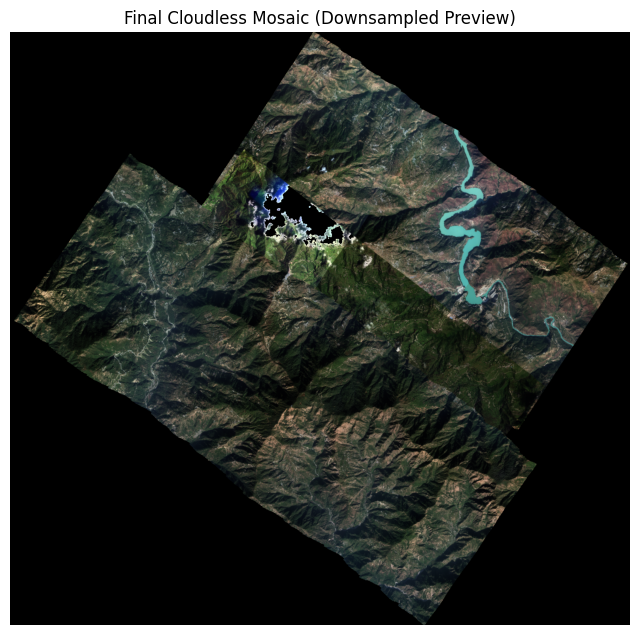

In [11]:
import rasterio
from rasterio.enums import Resampling
import matplotlib.pyplot as plt

# Define path again to avoid NameError
masked_path = "/content/cloudless_mosaic_cloudmasked.tif"

# Downsample factor (bigger = smaller image = safer)
preview_factor = 20

with rasterio.open(masked_path) as src:
    new_height = max(1, src.height // preview_factor)
    new_width = max(1, src.width // preview_factor)

    # Read downsized image
    preview = src.read(
        out_shape=(src.count, new_height, new_width),
        resampling=Resampling.bilinear
    )

# Convert to RGB
img = preview[:3].transpose(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.title("Final Cloudless Mosaic (Downsampled Preview)")
plt.axis("off")
plt.show()


In [ ]:
#cell 13

In [14]:
import glob

tif_files = sorted(glob.glob("/content/data/**/*.tif", recursive=True))
print("Found:", len(tif_files))
for t in tif_files:
    print(t)


Found: 10
/content/data/data/17_20241129_054359_147_SN50_L1C_MS_ortho_8bit_ncc_rendered_7_4.tif
/content/data/data/18_20241129_054358_499_SN50_L1C_MS_ortho_8bit_ncc_rendered_7_4.tif
/content/data/data/19_20241129_054357_865_SN50_L1C_MS_ortho_8bit_ncc_rendered_7_4.tif
/content/data/data/32_20240716_043003_536_SN32_L1C_MS_ortho_8bit_ncc_rendered_7_4.tif
/content/data/data/33_20240716_043002_901_SN32_L1C_MS_ortho_8bit_ncc_rendered_7_4.tif
/content/data/data/34_20240716_043002_264_SN32_L1C_MS_ortho_8bit_ncc_rendered_7_4.tif
/content/data/data/4_20241124_054616_030_SN50_L1C_MS_ortho_8bit_ncc_rendered_7_4.tif
/content/data/data/5_20241124_054615_396_SN50_L1C_MS_ortho_8bit_ncc_rendered_7_4.tif
/content/data/data/6_20241124_054614_762_SN50_L1C_MS_ortho_8bit_ncc_rendered_7_4.tif
/content/data/data/7_20241124_054614_128_SN50_L1C_MS_ortho_8bit_ncc_rendered_7_4.tif


In [15]:
tif_files = sorted(glob.glob("/content/data/**/*.tif", recursive=True))


Found tiles: 10
Demo files: ['/content/data/data/17_20241129_054359_147_SN50_L1C_MS_ortho_8bit_ncc_rendered_7_4.tif', '/content/data/data/18_20241129_054358_499_SN50_L1C_MS_ortho_8bit_ncc_rendered_7_4.tif']


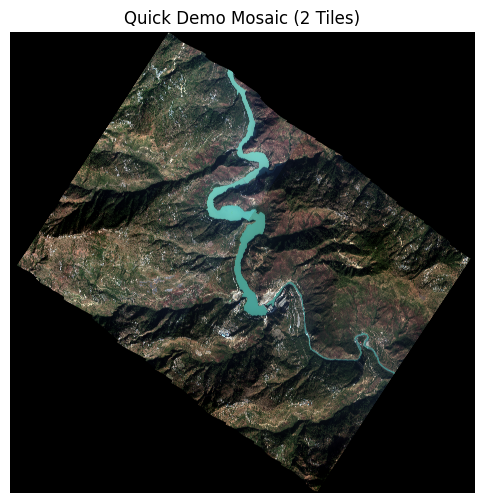

In [16]:
import rasterio
from rasterio.merge import merge
import matplotlib.pyplot as plt
import glob

# FIXED: recursive searching for tiles
tif_files = sorted(glob.glob("/content/data/**/*.tif", recursive=True))

print("Found tiles:", len(tif_files))
if len(tif_files) < 2:
    raise RuntimeError("❌ ERROR: Less than 2 tiles found. Verify data extract location!")

# Use first 2 tiles for demo
demo_files = tif_files[:2]
print("Demo files:", demo_files)

# Open and merge
datasets = [rasterio.open(fp) for fp in demo_files]
demo_mosaic, demo_transform = merge(datasets)

for ds in datasets:
    ds.close()

# Plot mosaic
rgb = demo_mosaic[:3].transpose(1, 2, 0)

plt.figure(figsize=(6, 6))
plt.imshow(rgb)
plt.title("Quick Demo Mosaic (2 Tiles)")
plt.axis("off")
plt.show()


In [18]:
# Create requirements.txt for reproducibility
with open("requirements.txt", "w") as f:
    f.write("rasterio\n")
    f.write("numpy\n")
    f.write("matplotlib\n")

print("✅ requirements.txt created successfully.")


✅ requirements.txt created successfully.
